In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from random import randrange
from torchvision.datasets import CIFAR10

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0,8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

#파이썬 코드를 실행하기 전에 외부 모듈을 다시 로드해라!
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
  """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
  train_data = CIFAR10('./CIFAR10',train=True, transform=transforms.ToTensor(),download=True)
  test_data = CIFAR10('./CIFAR10',train=False, transform=transforms.ToTensor(),download=True)

  X_train = train_data.data.astype('float')
  y_train = np.array(train_data.targets)

  X_test = test_data.data.astype('float')
  y_test = np.array(test_data.targets)

  mask = list(range(num_training,num_training+num_validation))
  X_val = X_train[mask]
  y_val = y_train[mask]

  mask = list(range(num_training))
  X_train = X_train[mask]
  y_train = y_train[mask]

  mask = np.random.choice(num_training, num_dev, replace=False)
  X_dev = X_train[mask]
  y_dev = y_train[mask]

  mask = list(range(num_test))
  X_test = X_test[mask]
  y_test = y_test[mask]

  X_train = X_train.reshape(X_train.shape[0],-1)
  X_val = X_val.reshape(X_val.shape[0],-1)
  X_dev = X_dev.reshape(X_dev.shape[0],-1)
  X_test = X_test.reshape(X_test.shape[0],-1)

  mean_img = np.mean(X_train,axis=0)
  X_train -= mean_img
  X_val -= mean_img
  X_dev -= mean_img
  X_test -= mean_img

  X_train = np.hstack([X_train,np.ones((X_train.shape[0],1))])
  X_val = np.hstack([X_val,np.ones((X_val.shape[0],1))])
  X_dev = np.hstack([X_dev,np.ones((X_dev.shape[0],1))])
  X_test = np.hstack([X_test,np.ones((X_test.shape[0],1))])

  return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Files already downloaded and verified
Files already downloaded and verified
Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


In [ ]:

def softmax_loss_naive(W, X, y, reg):
  """
  Softmax loss function, naive implementation (with loops)

  Inputs have dimension D, there are C classes, and we operate on minibatches
  of N examples.

  Inputs:
  - W: A numpy array of shape (D, C) containing weights.
  - X: A numpy array of shape (N, D) containing a minibatch of data.
  - y: A numpy array of shape (N,) containing training labels; y[i] = c means
    that X[i] has label c, where 0 <= c < C.
  - reg: (float) regularization strength

  Returns a tuple of:
  - loss as single float
  - gradient with respect to weights W; an array of same shape as W
  """
  # Initialize the loss and gradient to zero.
  loss = 0.0
  dW = np.zeros_like(W)

  num_train = X.shape[0]
  num_classes = W.shape[1]
  #############################################################################
  # TODO: Compute the softmax loss and its gradient using explicit loops.     #
  # Store the loss in loss and the gradient in dW. If you are not careful     #
  # here, it is easy to run into numeric instability. Don't forget the        #
  # regularization!                                                           #
  #############################################################################


  for i in range(num_train):
    score = X[i].dot(W)
    
    score-=score.max()
    exp = np.sum(np.exp(score))
    softmax_score = np.exp(score) / exp

    loss += -np.log(softmax_score[y[i]])

    for j in range(num_classes):
      if j != y[i]:
        dW[:,j] += X[i]*softmax_score[j]

    dW[:,y[i]] += (-1+softmax_score[y[i]])*X[i]

  loss /= num_train
  dW /= num_train

  loss+= reg * np.sum(W*W)
  dW += 2*reg*W
  #############################################################################
  #                          END OF YOUR CODE                                 #
  #############################################################################

  return loss, dW

In [ ]:
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.322505
sanity check: 2.302585


In [ ]:
def grad_check_sparse(f, x, analytic_grad, num_checks=10, h=1e-5):
  """
  sample a few random elements and only return numerical
  in this dimensions.
  """

  for i in range(num_checks):
    ix = tuple([randrange(m) for m in x.shape])

    oldval = x[ix]
    x[ix] = oldval + h # increment by h
    fxph = f(x) # evaluate f(x + h)
    x[ix] = oldval - h # increment by h
    fxmh = f(x) # evaluate f(x - h)
    x[ix] = oldval # reset

    grad_numerical = (fxph - fxmh) / (2 * h)
    grad_analytic = analytic_grad[ix]
    rel_error = abs(grad_numerical - grad_analytic) / (abs(grad_numerical) + abs(grad_analytic))
    print('numerical: %f analytic: %f, relative error: %e' % (grad_numerical, grad_analytic, rel_error))


In [ ]:
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 1.847373 analytic: 1.847373, relative error: 1.547603e-08
numerical: 2.442899 analytic: 2.442899, relative error: 6.723358e-09
numerical: -1.394004 analytic: -1.394004, relative error: 2.333160e-08
numerical: -0.202238 analytic: -0.202238, relative error: 2.296981e-07
numerical: -1.648245 analytic: -1.648245, relative error: 4.003286e-08
numerical: 0.489682 analytic: 0.489682, relative error: 2.332464e-08
numerical: 0.895044 analytic: 0.895044, relative error: 1.787237e-08
numerical: -4.277753 analytic: -4.277754, relative error: 2.807081e-08
numerical: 0.502563 analytic: 0.502563, relative error: 2.449294e-08
numerical: 0.728255 analytic: 0.728255, relative error: 5.214671e-08
numerical: 1.551612 analytic: 1.551612, relative error: 3.712285e-08
numerical: -1.558181 analytic: -1.558181, relative error: 4.727050e-08
numerical: -5.078285 analytic: -5.078285, relative error: 1.608142e-08
numerical: -0.920672 analytic: -0.920672, relative error: 1.977662e-08
numerical: 2.961581 

In [ ]:
def softmax_loss_vectorized(W, X, y, reg):
  """
  Softmax loss function, vectorized version.

  Inputs and outputs are the same as softmax_loss_naive.
  """
  # Initialize the loss and gradient to zero.
  loss = 0.0
  dW = np.zeros_like(W)
  num_train = X.shape[0]
  #############################################################################
  # TODO: Compute the softmax loss and its gradient using no explicit loops.  #
  # Store the loss in loss and the gradient in dW. If you are not careful     #
  # here, it is easy to run into numeric instability. Don't forget the        #
  # regularization!                                                           #
  #############################################################################
  score = X.dot(W)
  score -= np.reshape(score.max(axis=1),(num_train,1))
  exp_score = np.exp(score)
  softmax_score = exp_score / np.reshape(np.sum(exp_score,axis=1),(num_train,1))
 
  loss = np.sum(-np.log(softmax_score[range(num_train),y]))

  softmax_score[range(num_train),y] -=1 
  dW = X.T.dot(softmax_score)

  loss/=num_train
  dW/=num_train

  loss+=reg*np.sum(W*W)
  dW+=2*reg*W
  #############################################################################
  #                          END OF YOUR CODE                                 #
  #############################################################################

  return loss, dW

In [ ]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.322505e+00 computed in 0.164273s
vectorized loss: 2.322505e+00 computed in 0.014076s
Loss difference: 0.000000
Gradient difference: 0.000000


In [ ]:
class LinearClassifier(object):

  def __init__(self):
    self.W = None

  def train(self, X, y, learning_rate=1e-3, reg=1e-5, num_iters=100,
            batch_size=200, verbose=False):
    """
    Train this linear classifier using stochastic gradient descent.

    Inputs:
    - X: A numpy array of shape (N, D) containing training data; there are N
      training samples each of dimension D.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c
      means that X[i] has label 0 <= c < C for C classes.
    - learning_rate: (float) learning rate for optimization.
    - reg: (float) regularization strength.
    - num_iters: (integer) number of steps to take when optimizing
    - batch_size: (integer) number of training examples to use at each step.
    - verbose: (boolean) If true, print progress during optimization.

    Outputs:
    A list containing the value of the loss function at each training iteration.
    """
    num_train, dim = X.shape
    num_classes = np.max(y) + 1 # assume y takes values 0...K-1 where K is number of classes
    if self.W is None:
      # lazily initialize W
      self.W = 0.001 * np.random.randn(dim, num_classes)

    # Run stochastic gradient descent to optimize W
    loss_history = []
    for it in range(num_iters):
      X_batch = None
      y_batch = None

      #########################################################################
      # TODO:                                                                 #
      # Sample batch_size elements from the training data and their           #
      # corresponding labels to use in this round of gradient descent.        #
      # Store the data in X_batch and their corresponding labels in           #
      # y_batch; after sampling X_batch should have shape (dim, batch_size)   #
      # and y_batch should have shape (batch_size,)                           #
      #                                                                       #
      # Hint: Use np.random.choice to generate indices. Sampling with         #
      # replacement is faster than sampling without replacement.              #
      #########################################################################
      mask = np.random.choice(num_train,batch_size,replace=False)
      X_batch = X[mask]
      y_batch = y[mask]
      #########################################################################
      #                       END OF YOUR CODE                                #
      #########################################################################

      # evaluate loss and gradient
      loss, grad = self.loss(X_batch, y_batch, reg)
      loss_history.append(loss)

      # perform parameter update
      #########################################################################
      # TODO:                                                                 #
      # Update the weights using the gradient and the learning rate.          #
      #########################################################################
      self.W -= learning_rate * grad
      #########################################################################
      #                       END OF YOUR CODE                                #
      #########################################################################

      if verbose and it % 100 == 0:
        print('iteration %d / %d: loss %f' % (it, num_iters, loss))

    return loss_history

  def predict(self, X):
    """
    Use the trained weights of this linear classifier to predict labels for
    data points.

    Inputs:
    - X: A numpy array of shape (N, D) containing training data; there are N
      training samples each of dimension D.

    Returns:
    - y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
      array of length N, and each element is an integer giving the predicted
      class.
    """
    y_pred = np.zeros(X.shape[0])
    ###########################################################################
    # TODO:                                                                   #
    # Implement this method. Store the predicted labels in y_pred.            #
    ###########################################################################
    score=X.dot(self.W)
    y_pred = score.argmax(axis=1)
    ###########################################################################
    #                           END OF YOUR CODE                              #
    ###########################################################################
    return y_pred
  
  def loss(self, X_batch, y_batch, reg):
    """
    Compute the loss function and its derivative. 
    Subclasses will override this.

    Inputs:
    - X_batch: A numpy array of shape (N, D) containing a minibatch of N
      data points; each point has dimension D.
    - y_batch: A numpy array of shape (N,) containing labels for the minibatch.
    - reg: (float) regularization strength.

    Returns: A tuple containing:
    - loss as a single float
    - gradient with respect to self.W; an array of the same shape as W
    """
    pass


class Softmax(LinearClassifier):
  """ A subclass that uses the Softmax + Cross-entropy loss function """

  def loss(self, X_batch, y_batch, reg):
    return softmax_loss_vectorized(self.W, X_batch, y_batch, reg)


In [ ]:
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
for learning_rate in learning_rates:
  for reg in regularization_strengths:
    softmax = Softmax()
    softmax.train(X_train,y_train,learning_rate=learning_rate,
                  reg=reg,num_iters=1500,batch_size=200,verbose=True)
    y_pred = softmax.predict(X_train)
    train_accr = np.mean((y_pred == y_train))
    
    y_pred = softmax.predict(X_val)
    val_accr = np.mean((y_pred==y_val))

    results[(learning_rate,reg)] = (train_accr,val_accr)
    if best_val < val_accr:
      best_val = val_accr
      best_softmax = softmax
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 773.541109
iteration 100 / 1500: loss 283.746495
iteration 200 / 1500: loss 105.337530
iteration 300 / 1500: loss 39.930951
iteration 400 / 1500: loss 15.915878
iteration 500 / 1500: loss 7.102282
iteration 600 / 1500: loss 3.953330
iteration 700 / 1500: loss 2.727936
iteration 800 / 1500: loss 2.419128
iteration 900 / 1500: loss 2.152951
iteration 1000 / 1500: loss 2.126483
iteration 1100 / 1500: loss 2.098281
iteration 1200 / 1500: loss 2.115546
iteration 1300 / 1500: loss 2.043977
iteration 1400 / 1500: loss 2.087210
iteration 0 / 1500: loss 1529.851119
iteration 100 / 1500: loss 206.246148
iteration 200 / 1500: loss 29.369744
iteration 300 / 1500: loss 5.762940
iteration 400 / 1500: loss 2.639423
iteration 500 / 1500: loss 2.244478
iteration 600 / 1500: loss 2.133646
iteration 700 / 1500: loss 2.140302
iteration 800 / 1500: loss 2.134912
iteration 900 / 1500: loss 2.173687
iteration 1000 / 1500: loss 2.106361
iteration 1100 / 1500: loss 2.158147
iteration 1

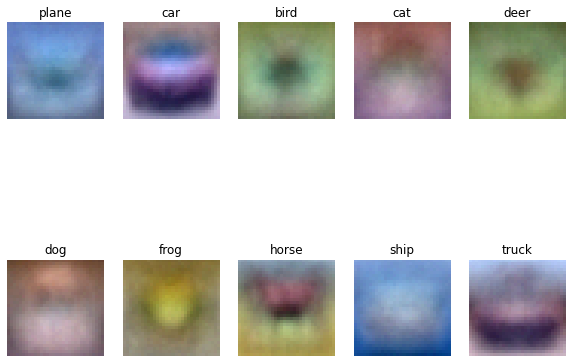

In [ ]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])